# Mulitple Convolutions in RGB (or mult-channel)  image

![title](figures/convolution_graph.PNG)

In deep learning the filter needs to have the same amount of channels as the input image. Each filter will result in one output channel. In other words, when a kernel is applied to an RGB (or an image with Multiple channels) then effectively sum up the output matrices (along with a bias terms) to yield a single-channel feature map.
The number of **channels** of the output image will be equal to the number of **filters** applied.

In [3]:
!pip install Pillow


     |████████████████████████████████| 2.2 MB 1.5 MB/s eta 0:00:01


In [4]:
#Python Imaging Library
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

In [71]:
#do the standard imports
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

import numpy as np
import matplotlib.pyplot as plt

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ## uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms.
    torch.backends.cudnn.enabled   = False  ## does not enable the inbuilt cudnn deep learning library for training neural networks

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available(): ## run on GPUs if available
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
#Use torchvision.datasets.CIFAR10 to load the CIFAR10 dataset
cifar10_train = CIFAR10("./", download=True, train=True)
cifar10_test = CIFAR10("./", download=True, train=False)


No GPU available!
Files already downloaded and verified
Files already downloaded and verified


In [73]:
#convert the dataset to a torch tensor
X_train = torch.tensor(cifar10_train.data).float()
#take only the first 50 images 
#and reshape to batchsize, channels, height, width
small_tensor = X_train[0:50,:].transpose(3,1).transpose(2,3)
#confirm
small_tensor.shape

torch.Size([50, 3, 32, 32])

In [74]:
single_image = small_tensor[0]
single_image.shape

torch.Size([3, 32, 32])

In [78]:
grey_image = single_image[0]
grey_image.shape

torch.Size([32, 32])

Pytorch works on input tensors whose shape correspands to :

**(batch_size,  num_input_channels,  image_height,  image_width)**

Kernels must be tensors of size: 


**(out_channels,  in_channels,  kernel_height,  kernel_width )**

out_channels: number of kernels, in_channels: number of channels in one kernel

Arguments of torch.nn.Conv2d

**(in_channel,  out_channel,  ker_size)**

In [161]:
#create the kernel
#out_channels, in_channels, kernel_height, kernel_width )
#out_channels: number of kernels, in_channels: number of channels in one kernel
SOBEL_VERTICAL = [[1, 0, -1],
                  [2, 0, -2],
                  [1, 0, -1]]
SOBEL_HORIZONTAL = [[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]]
PREWITT_VERTICAL = [[1, 0, -1],
                    [1, 0, -1],
                    [1, 0, -1]]
single_image = small_tensor[0:1,:]
#single image with 4 axes
print(single_image.shape)
#create a kernel with 4 axes
kernel_3d = torch.tensor([SOBEL_VERTICAL, SOBEL_HORIZONTAL, PREWITT_VERTICAL]).float()
kernel_3d.unsqueeze_(0)
kernel_3d.shape

torch.Size([1, 3, 32, 32])


torch.Size([1, 3, 3, 3])

In [ ]:
#(batch_size, num_input_channels, image_height, image_width)
#out_channels, in_channels, kernel_height, kernel_width

In [185]:
from abc import ABC, abstractmethod
from devito import Operator, Function
from numpy import array


class Layer(ABC):
    def __init__(self, input_data):
        self._input_data = input_data
        self._R = self._allocate()

    @abstractmethod
    def _allocate(self) -> Function:
        # This method should return a Function object corresponding to
        # an output of the layer.
        pass

    def execute(self) -> (Operator, array):
        op = Operator(self.equations())
        op.cfunction

        return (op, self._R.data)

    @abstractmethod
    def equations(self) -> list:
        pass

In [453]:
class Subsampling(Layer):
    def __init__(self, kernel_size, feature_map, function,
                 stride=(1, 1), padding=(0, 0), activation=None,
                 bias=0):
        # All sizes are expressed as (rows, columns).

        self._error_check(kernel_size, feature_map, stride, padding)

        self._kernel_size = kernel_size
        self._function = function
        self._activation = activation
        self._bias = bias

        self._stride = stride
        self._padding = padding

        super().__init__(input_data=feature_map)

    def _error_check(self, kernel_size, feature_map, stride, padding):
        if feature_map is None or len(feature_map) == 0:
            raise Exception("Feature map must not be empty")

        if kernel_size is None or len(kernel_size) != 2:
            raise Exception("Kernel size is incorrect")

        if stride is None or len(stride) != 2:
            raise Exception("Stride is incorrect")

        if stride[0] < 1 or stride[1] < 1:
            raise Exception("Stride cannot be less than 1")

        if padding is None or len(padding) != 2:
            raise Exception("Padding is incorrect")

        if padding[0] < 0 or padding[1] < 0:
            raise Exception("Padding cannot be negative")

        map_height = len(feature_map) + 2 * padding[0]
        map_width = len(feature_map[0]) + 2 * padding[1]
        kernel_height, kernel_width = kernel_size

        if (map_height - kernel_height) % stride[0] != 0 or \
           (map_width - kernel_width) % stride[1] != 0:
            raise Exception("Stride " + str(stride) + " is not "
                            "compatible with feature map, kernel and padding "
                            "sizes")

    def _allocate(self):
        map_height = len(self._input_data) + 2 * self._padding[0]
        map_width = len(self._input_data[0]) + 2 * self._padding[1]
        kernel_height, kernel_width = self._kernel_size

        gridB = Grid(shape=(map_height, map_width))
        B = Function(name='B', grid=gridB, space_order=0)

        a, b = dimensions('a b')
        gridR = Grid(shape=((map_height - kernel_height + self._stride[0])
                            // self._stride[0],
                            (map_width - kernel_width + self._stride[1])
                            // self._stride[1]),
                     dimensions=(a, b))
        R = Function(name='R', grid=gridR, space_order=0)

        for i in range(self._padding[0], map_height - self._padding[0]):
            B.data[i] = \
                np.concatenate(([0] * self._padding[1],
                                self._input_data[i - self._padding[0]],
                                [0] * self._padding[1]))

        self._B = B

        return R

    def equations(self):
        a, b = self._B.dimensions
        kernel_height, kernel_width = self._kernel_size

        rhs = self._function([self._B[self._stride[0] * a + i,
                                      self._stride[1] * b + j]
                              for i in range(kernel_height)
                              for j in range(kernel_width)]) + self._bias

        if self._activation is not None:
            rhs = self._activation(rhs)

        return [Eq(self._R[a, b], rhs)]



In [455]:
#unmodified for 2D
class Conv(Layer):
    def __init__(self, kernel, input_data, stride=(1, 1), padding=(0, 0),
                 activation=None, bias=0):
        self._error_check(kernel, input_data, stride, padding)

        self._kernel = kernel

        self._layer = Subsampling(kernel_size=(len(kernel), len(kernel[0])),
                                  feature_map=input_data,
                                  function=self._convolve,
                                  stride=stride,
                                  padding=padding,
                                  activation=activation,
                                  bias=bias)

    def _convolve(self, values):
        kernel_size = (len(self._kernel), len(self._kernel[0]))

        acc = 0

        for i in range(kernel_size[0]):
            for j in range(kernel_size[1]):
                acc += self._kernel[i][j] * values[i * kernel_size[0] + j]

        return acc

    def _error_check(self, kernel, input_data, stride, padding):
        if input_data is None or len(input_data) == 0:
            raise Exception("Input data must not be empty")

        if kernel is None or len(kernel) == 0:
            raise Exception("Kernel must not be empty")

        different_row_length = False
        for row in kernel:
            if len(row) != len(kernel[0]):
                different_row_length = True
                break

        if different_row_length:
            raise Exception("Kernel has an invalid shape")

        different_row_length = False
        for row in input_data:
            if len(row) != len(input_data[0]):
                different_row_length = True
                break

        if different_row_length:
            raise Exception("Input data have an invalid shape")

        if stride is None or len(stride) != 2:
            raise Exception("Stride is incorrect")

        if stride[0] < 1 or stride[1] < 1:
            raise Exception("Stride cannot be less than 1")

        if padding is None or len(padding) != 2:
            raise Exception("Padding is incorrect")

        if padding[0] < 0 or padding[1] < 0:
            raise Exception("Padding cannot be negative")

        map_height = len(input_data) + 2 * padding[0]
        map_width = len(input_data[0]) + 2 * padding[1]
        kernel_height, kernel_width = len(kernel), len(kernel[0])

        if (map_height - kernel_height) % stride[0] != 0 or \
           (map_width - kernel_width) % stride[1] != 0:
            raise Exception("Stride " + str(stride) + " is not "
                            "compatible with input data, kernel and padding "
                            "sizes")

    def _allocate(self):
        pass

    def execute(self):
        return self._layer.execute()

    def equations(self):
        return self._layer.equations()

In [316]:
A = Conv(kernel_3d[0,2].tolist(),single_image[0,2].tolist())
#A.equations()
tup = A.execute()
tup[0].apply()
tup[1].shape

Operator `Kernel` generated in 0.12 s
  * lowering.IET: 0.09 s (78.1 %)
     * specializing.IET: 0.06 s (52.1 %)
        * make_parallel: 0.03 s (26.1 %)
Flops reduction after symbolic optimization: [0 --> 0]


map_height 32 kernel_height 3
map_height 32 kernel_height 3


Operator `Kernel` fetched `/tmp/devito-jitcache-uid0/73c46b1e7a8a952f08325f742b666ecbd5869734.c` in 0.11 s from jit-cache
Operator `Kernel` run in 0.01 s
* section0 computed in 0.01 s
Performance[mode=advanced] arguments: {'nthreads_nonaffine': 1}


(30, 30)

In [324]:
B = ConvConv(kernel_3d[0,2].tolist(),single_image[0,2].tolist())
#A.equations()
tupB = B.execute()
tupB[0].apply()
tupB[1].shape

Operator `Kernel` generated in 0.13 s
  * lowering.IET: 0.08 s (61.7 %)
     * specializing.IET: 0.05 s (38.6 %)
  * lowering.Expressions: 0.03 s (23.2 %)
  * lowering.Clusters: 0.03 s (23.2 %)
Flops reduction after symbolic optimization: [17 --> 17]
Operator `Kernel` jit-compiled `/tmp/devito-jitcache-uid0/8a7c16ae9357ef4866d16d388b57e0f0fffbdfc1.c` in 0.36 s with `GNUCompiler`
Operator `Kernel` run in 0.01 s
* section0 computed in 0.01 s
Performance[mode=advanced] arguments: {'nthreads': 1}


(32, 32)

In [318]:
np.allclose(tup[1],output[0][0].detach().numpy())

False

In [266]:
#kernel_height
kernel = [[1,2],[1,2]]
kernel_height, kernel_width = len(kernel), len(kernel[0])
kernel_height


2

In [286]:
input_data = single_image[0,2]
B = Subsampling(kernel,input_data, max)
B.equations()

map_height 32 kernel_height [1, 2]


TypeError: unsupported operand type(s) for -: 'int' and 'list'

In [140]:
kernel_size = (len(kernel_3d), len(kernel_3d[0]),(kernel_3d.shape[2]),kernel_3d.shape[2])

In [327]:
conop.weight.shape

torch.Size([1, 3, 3, 3])

PyTorch Implementations for a batch

In [244]:
conop = nn.Conv2d(3,1,3, bias = False)
input = single_image
#set our own weights
conop.weight = torch.nn.Parameter( kernel_3d )
output = conop(input)

In [21]:
Lecture_kernel   = [[2, -3, 2],
                    [1, 0, 1],
                    [2, -3, 3]]
img_lec = [[4, 2, 3, 3],
                  [2, 1, 2, 5],
                  [3, 2, 0, 3],
                  [1, 2, 3, 1]]
result = run(Lecture_kernel,
                 img_lec)

Operator `Kernel` generated in 0.14 s
  * lowering.IET: 0.09 s (66.2 %)
     * specializing.IET: 0.07 s (51.5 %)
        * make_parallel: 0.04 s (29.4 %)
  * lowering.Expressions: 0.03 s (22.1 %)
Flops reduction after symbolic optimization: [0 --> 0]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid0/8f9d8725a145adace0c3cfb447643168108e4130.c` in 0.03 s from jit-cache
Operator `Kernel` run in 0.01 s
* section0 computed in 0.01 s
Performance[mode=advanced] arguments: {'nthreads_nonaffine': 1}


#define _POSIX_C_SOURCE 200809L
#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"
#include "omp.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
} ;


int Kernel(struct dataobj *restrict A_vec, struct dataobj *restrict B_vec, struct dataobj *restrict R_vec, struct profiler * timers, const int x_M, const int x_m, const int y_M, const int y_m, const int nthreads_nonaffine)
{
  float (*restrict A)[A_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[A_vec->size[1]]) A_vec->data;
  float (*restrict B)[B_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[B_vec->size[1]]) B_vec->data;
  float (*restrict R)[R_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[R_vec->size[1]]) R_vec->data;

  /* Flush denormal numbers to zero in hardware */
  _MM_SET_DENORMALS_ZERO_MODE(_MM_DENORMALS_ZERO_ON);
 

In [44]:
print(result[1:-1,1:-1])
#same as
#grad = signal.convolve2d(img_lec, Lecture_kernel, boundary='fill', mode='same') = with halo
#grad = signal.convolve2d(img_lec, Lecture_kernel, boundary='fill', mode='valid') = only the inside
print(result)

[[16. 19.]
 [12.  9.]]
[[ -2.  12.  11.  -8.]
 [-12.  16.  19.  -7.]
 [ -1.  12.   9.  -6.]
 [ -3.   7.  15.  -6.]]


In [61]:
from scipy import signal
Lecture_kernel_array = np.array(Lecture_kernel)
Lecture_kernel_array = np.flip(Lecture_kernel_array)
print(Lecture_kernel_array)
grad = signal.convolve2d(img_lec, Lecture_kernel_array, boundary='fill', mode='valid')
grad

[[ 3 -3  2]
 [ 1  0  1]
 [ 2 -3  2]]


array([[12, 20],
       [13,  9]])

In [63]:
h = np.array([[1,2,3],[4,5,6],[7,8,9]])
h.T

array([[1, 4, 7],
       [2, 5, 8],
       [3, 6, 9]])

In [64]:
np.flip(h)

array([[9, 8, 7],
       [6, 5, 4],
       [3, 2, 1]])

In [ ]:
#12 20
#13 9

In [23]:
"""
Import the image, and split it into channels
"""
image_path = "figures/rsm.jpg"
img_raw = Image.open(image_path)
r, g, b = img_raw.split()
#im = Image.merge("RGB", (b, g, r))

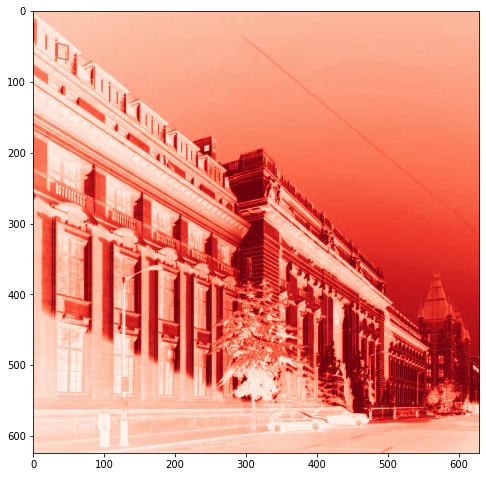

In [19]:
"""
Convert the separete channels into 2D images
"""
#convert red channel to 2D array
red_2d = np.array(r.getdata(band=0),float)
red_2d.shape = (r.size[1], r.size[0])
#convert green channel to 2D array
green_2d = np.array(g.getdata(band=0),float)
green_2d.shape = (g.size[1], g.size[0])
#convert blue channel to 2D array
blue_2d = np.array(b.getdata(band=0),float)
blue_2d.shape = (b.size[1], b.size[0])
#plot the image
fig = plt.figure(figsize=(8,12))
ax1 = fig.add_subplot(111)
ax1.imshow(r, cmap='Reds')

Each Channel of the output image is the sum of the filters applied to each channel

In [22]:
conv_channel_1 = run(SOBEL_VERTICAL,red_2d) + run(SOBEL_HORIZONTAL,green_2d) + run(PREWITT_VERTICAL,blue_2d)
conv_channel_2 = run(SOBEL_HORIZONTAL,red_2d) + run(PREWITT_VERTICAL,green_2d) + run(SOBEL_HORIZONTAL,blue_2d)

Operator `Kernel` generated in 0.12 s
  * lowering.IET: 0.08 s (72.7 %)
     * specializing.IET: 0.06 s (54.6 %)
        * make_parallel: 0.03 s (27.3 %)
Flops reduction after symbolic optimization: [0 --> 0]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid0/8f9d8725a145adace0c3cfb447643168108e4130.c` in 0.04 s from jit-cache
Operator `Kernel` run in 0.01 s
* section0 computed in 0.01 s
Performance[mode=advanced] arguments: {'nthreads_nonaffine': 2}
Operator `Kernel` generated in 0.10 s
  * lowering.IET: 0.07 s (71.0 %)
     * specializing.IET: 0.05 s (50.8 %)
        * make_parallel: 0.03 s (30.5 %)
  * lowering.Expressions: 0.02 s (20.3 %)
Flops reduction after symbolic optimization: [0 --> 0]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid0/8f9d8725a145adace0c3cfb447643168108e4130.c` in 0.04 s from jit-cache
Operator `Kernel` run in 0.01 s
* section0 computed in 0.01 s
Performance[mode=advanced] arguments: {'nthreads_nonaffine': 2}
Operator `Kernel` generated in 0.13 s
  * lo

In [392]:
#save this
class ConvConv_channels(Layer):
    def __init__(self, kernel, input_data, activation=None, bias=0):
        #self._error_check(kernel, input_data)

        self._kernel = kernel
        self._activation = activation
        self._bias = bias
        super().__init__(input_data=input_data)

    #error checks
    #input tensor
    #(batch_size, num_input_channels, image_height, image_width)
    #Kernels must be tensors of size:
    #(out_channels, in_channels, kernel_height, kernel_width )
    #here only 3 axes

    def _allocate(self):
        gridA = Grid(shape=(self._kernel.shape[0], self._kernel.shape[1], self._kernel.shape[2]),
                     dimensions=dimensions('k m n'))
        A = Function(name='A', grid=gridA, space_order=0)
        A.data[:] = self._kernel

        gridBR = Grid(shape=(self._input_data.shape[0], self._input_data.shape[1], self._input_data.shape[2] ))

        B = Function(name='B', grid=gridBR, space_order=1)
        B.data[:] = self._input_data

        self._A = A
        self._B = B

        R = Function(name='R', grid=gridBR, space_order=0)
        return R

    def equations(self):
        z, x, y = self._B.dimensions
        kernel_channels, kernel_rows, kernel_cols = self._A.shape
        
        rhs = sum([sum([self._A[channel,kernel_rows - i - 1,
                           kernel_cols - j - 1] *
                   self._B[channel, x - kernel_rows // 2 + i,
                           y - kernel_cols // 2 + j]
                   for i in range(kernel_rows)
                   for j in range(kernel_cols)])
                   for channel in range(kernel_channels)])

       
    
        if self._activation is not None:
            rhs = self._activation(rhs)

        return [Eq(self._R[z, x, y], rhs)]

C = ConvConv_channels(kernel_3d[0],single_image[0])
#A.equations()
tupC = C.execute()
tupC[0].apply()
tupC[1].shape

Operator `Kernel` generated in 0.17 s
  * lowering.IET: 0.08 s (49.2 %)
     * specializing.IET: 0.05 s (30.8 %)
  * lowering.Expressions: 0.04 s (24.6 %)
  * lowering.Clusters: 0.04 s (24.6 %)
Flops reduction after symbolic optimization: [35 --> 35]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid0/9b02f189eaee3ed6cb70a4c71bba1c4f389eca97.c` in 0.07 s from jit-cache
Operator `Kernel` run in 0.01 s
* section0 computed in 0.01 s
Performance[mode=advanced] arguments: {'nthreads': 1}


(3, 32, 32)

In [390]:
#we get the same tuple 3 times
single_image[0].shape


torch.Size([3, 32, 32])

In [370]:
output

tensor([[[[ 1.7100e+02, -1.3700e+02, -2.8200e+02, -3.1700e+02, -1.8900e+02,
            1.2000e+01,  1.1400e+02,  1.6700e+02,  2.2900e+02,  1.9900e+02,
            1.0700e+02,  5.0000e+01,  8.4000e+01,  8.1000e+01,  2.0000e+00,
            7.3000e+01,  1.7500e+02,  3.9000e+01, -2.4000e+01,  8.0000e+01,
            1.6000e+01,  2.1000e+01,  9.5000e+01,  5.5000e+01,  7.8000e+01,
            1.0900e+02,  1.2800e+02,  2.0400e+02,  2.3700e+02,  2.1300e+02],
          [-1.7000e+02, -4.5600e+02, -4.1900e+02, -3.1100e+02, -1.0700e+02,
            9.5000e+01,  1.3800e+02,  6.1000e+01, -1.7000e+01, -1.0000e+00,
            8.0000e+00, -1.6700e+02, -1.6700e+02, -6.6000e+01, -5.6000e+01,
            3.1000e+01,  2.2000e+01, -6.1000e+01, -8.8000e+01, -5.6000e+01,
           -7.9000e+01, -2.5000e+01,  4.5000e+01, -3.7000e+01, -6.2000e+01,
           -6.5000e+01, -3.0000e+00,  1.0400e+02,  6.9000e+01,  9.3000e+01],
          [-2.8800e+02, -4.7600e+02, -2.8300e+02, -1.2100e+02,  4.0000e+00,
          

In [394]:
class ConvConv_filters(Layer):
    def __init__(self, kernel, input_data, activation=None, bias=0):
        #self._error_check(kernel, input_data)

        self._kernel = kernel
        self._activation = activation
        self._bias = bias
        super().__init__(input_data=input_data)

    #error checks
    #input tensor
    #(batch_size, num_input_channels, image_height, image_width)
    #Kernels must be tensors of size:
    #(out_channels, in_channels, kernel_height, kernel_width )
    #here only 3 axes

    def _allocate(self):
        gridA = Grid(shape=(self._kernel.shape[0], self._kernel.shape[1], self._kernel.shape[2],self._kernel.shape[3]),
                     dimensions=dimensions('k l m n'))
        A = Function(name='A', grid=gridA, space_order=0)
        A.data[:] = self._kernel

        gridBR = Grid(shape=(self._input_data.shape[0], self._input_data.shape[1], self._input_data.shape[2] ))

        B = Function(name='B', grid=gridBR, space_order=1)
        B.data[:] = self._input_data

        self._A = A
        self._B = B

        R = Function(name='R', grid=gridBR, space_order=0)
        return R

    def equations(self):
        z, x, y = self._B.dimensions
        kernel_outchannels, kernel_channels, kernel_rows, kernel_cols = self._A.shape
        
        rhs = ([sum([sum([self._A[out_channel ,channel,kernel_rows - i - 1,
                           kernel_cols - j - 1] *
                   self._B[channel, x - kernel_rows // 2 + i,
                           y - kernel_cols // 2 + j]
                   for i in range(kernel_rows)
                   for j in range(kernel_cols)])
                   for channel in range(kernel_channels)])
                for out_channel in range(kernel_outchannels)])

       
    
        if self._activation is not None:
            rhs = self._activation(rhs)

        return [Eq(self._R[z, x, y], rhs)]

C = ConvConv_channels(kernel_3d[0],single_image[0])
#A.equations()
tupC = C.execute()
tupC[0].apply()
tupC[1].shape

Operator `Kernel` generated in 0.19 s
  * lowering.IET: 0.08 s (42.9 %)
     * specializing.IET: 0.05 s (26.8 %)
  * lowering.Expressions: 0.06 s (32.2 %)
  * lowering.Clusters: 0.04 s (21.5 %)
Flops reduction after symbolic optimization: [35 --> 35]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid0/9b02f189eaee3ed6cb70a4c71bba1c4f389eca97.c` in 0.09 s from jit-cache
Operator `Kernel` run in 0.01 s
* section0 computed in 0.01 s
Performance[mode=advanced] arguments: {'nthreads': 1}


(3, 32, 32)

In [410]:
class ConvConv_images(Layer):
    def __init__(self, kernel, input_data, activation=None, bias=0):
        #self._error_check(kernel, input_data)

        self._kernel = kernel
        self._activation = activation
        self._bias = bias
        super().__init__(input_data=input_data)

    #error checks
    #input tensor
    #(batch_size, num_input_channels, image_height, image_width)
    #Kernels must be tensors of size:
    #(out_channels, in_channels, kernel_height, kernel_width )
    #here only 3 axes

    def _allocate(self):
        gridA = Grid(shape=(self._kernel.shape[0], self._kernel.shape[1],\
                            self._kernel.shape[2],self._kernel.shape[3]),
                     dimensions=dimensions('k l m n'))
        A = Function(name='A', grid=gridA, space_order=0)
        A.data[:] = self._kernel

        gridBR = Grid(shape=(self._input_data.shape[0], self._input_data.shape[1],\
                             self._input_data.shape[2], self._input_data.shape[3]), 
                     dimensions=dimensions('k l m n'))

        B = Function(name='B', grid=gridBR, space_order=1)
        B.data[:] = self._input_data

        self._A = A
        self._B = B

        R = Function(name='R', grid=gridBR, space_order=0)
        return R

    def equations(self):
        z, t, x, y = self._B.dimensions
        images = self._B.shape[0]
        kernel_outchannels, kernel_channels, kernel_rows, kernel_cols = self._A.shape
        
        rhs = ([([sum([sum([self._A[out_channel ,channel,kernel_rows - i - 1,
                           kernel_cols - j - 1] *
                   self._B[image, channel, x - kernel_rows // 2 + i,
                           y - kernel_cols // 2 + j]
                   for i in range(kernel_rows)
                   for j in range(kernel_cols)])
                   for channel in range(kernel_channels)])
                for out_channel in range(kernel_outchannels)])
                for image in range(images)])

       
    
        if self._activation is not None:
            rhs = self._activation(rhs)

        return [Eq(self._R[z, t, x, y], rhs)]

C = ConvConv_images(kernel_3d,single_image)
#A.equations()
tupC = C.execute()
tupC[0].apply()
tupC[1].shape

SympifyError: SympifyError: [[A[0, 0, 0, 0]*B[0, 0, m + 1, n + 1] + A[0, 0, 0, 1]*B[0, 0, m + 1, n] + A[0, 0, 0, 2]*B[0, 0, m + 1, n - 1] + A[0, 0, 1, 0]*B[0, 0, m, n + 1] + A[0, 0, 1, 1]*B[0, 0, m, n] + A[0, 0, 1, 2]*B[0, 0, m, n - 1] + A[0, 0, 2, 0]*B[0, 0, m - 1, n + 1] + A[0, 0, 2, 1]*B[0, 0, m - 1, n] + A[0, 0, 2, 2]*B[0, 0, m - 1, n - 1] + A[0, 1, 0, 0]*B[0, 1, m + 1, n + 1] + A[0, 1, 0, 1]*B[0, 1, m + 1, n] + A[0, 1, 0, 2]*B[0, 1, m + 1, n - 1] + A[0, 1, 1, 0]*B[0, 1, m, n + 1] + A[0, 1, 1, 1]*B[0, 1, m, n] + A[0, 1, 1, 2]*B[0, 1, m, n - 1] + A[0, 1, 2, 0]*B[0, 1, m - 1, n + 1] + A[0, 1, 2, 1]*B[0, 1, m - 1, n] + A[0, 1, 2, 2]*B[0, 1, m - 1, n - 1] + A[0, 2, 0, 0]*B[0, 2, m + 1, n + 1] + A[0, 2, 0, 1]*B[0, 2, m + 1, n] + A[0, 2, 0, 2]*B[0, 2, m + 1, n - 1] + A[0, 2, 1, 0]*B[0, 2, m, n + 1] + A[0, 2, 1, 1]*B[0, 2, m, n] + A[0, 2, 1, 2]*B[0, 2, m, n - 1] + A[0, 2, 2, 0]*B[0, 2, m - 1, n + 1] + A[0, 2, 2, 1]*B[0, 2, m - 1, n] + A[0, 2, 2, 2]*B[0, 2, m - 1, n - 1]]]

In [516]:
class Subsampling_4d(Layer):
    def __init__(self, kernel_size, feature_map, function,
                 stride=(1, 1), padding=(0, 0), activation=None,
                 bias=0):
        # All sizes are expressed as (rows, columns).

        #self._error_check(kernel_size, feature_map, stride, padding)

        self._kernel_size = kernel_size
        self._function = function
        self._activation = activation
        self._bias = bias

        self._stride = stride
        self._padding = padding

        super().__init__(input_data=feature_map)


    def _allocate(self):
        map_height = self._input_data.shape[2] + 2 * self._padding[0]
        map_width = self._input_data.shape[3] + 2 * self._padding[1]
        kernel_height, kernel_width = self._kernel_size
        a, b, c, d = dimensions('a b c d')
        gridB = Grid(shape=(self._input_data.shape[0], self._input_data.shape[1], map_height, map_width),\
                    dimensions=(a, b, c, d))
        B = Function(name='B', grid=gridB, space_order=0)

        e, f, g, h = dimensions('e f g h')
        gridR = Grid(shape=( self._input_data.shape[0],  self._input_data.shape[1],\
                            (map_height - kernel_height + self._stride[0])
                            // self._stride[0],
                            (map_width - kernel_width + self._stride[1])
                            // self._stride[1]),
                     dimensions=(e, f, g, h))
        print(gridR)
        R = Function(name='R', grid=gridR, space_order=0)
        #add padding to start and end of each row
        for image in range(self._input_data.shape[0]):
            for channel in range(self._input_data.shape[1]):
                for i in range(self._padding[0], map_height - self._padding[0]):
                    B.data[image, channel, i] = \
                        np.concatenate(([0] * self._padding[1],
                                        self._input_data[image, channel, i - self._padding[0]],
                                        [0] * self._padding[1]))

        self._B = B
        print("b dim", self._B.dimensions)
        print("b self shape", self._B.shape)
        print("b  shape", B.shape)
        return R

    def equations(self):
        a, b, c, d = self._B.dimensions
        kernel_height, kernel_width = self._kernel_size
        images = self._input_data.shape[0]
        channels = self._input_data.shape[1]
        print(channels)
        rhs = self._function([self._B[image, channel, self._stride[0] * c + i,
                                      self._stride[1] * d + j]
                              for image in range(images)
                              for channel in range(channels)
                              for i in range(kernel_height)
                              for j in range(kernel_width)
                              ]) + self._bias

        if self._activation is not None:
            rhs = self._activation(rhs)

        return [Eq(self._R[a, b, c, d], rhs)]

Sample_obj4 = Subsampling_4d((2,2),single_image, lambda l: sympy.Max(*l))
#A.equations()
tup4 = Sample_obj4.execute()
tup4[0].apply()
tup4[1].shape

/app/devito/types/grid.py:206: RuntimeWarning: divide by zero encountered in true_divide
  spacing = (np.array(self.extent) / (np.array(self.shape) - 1)).astype(self.dtype)


Grid[extent=(1.0, 1.0, 1.0, 1.0), shape=(1, 3, 31, 31), dimensions=(e, f, g, h)]
b dim (a, b, c, d)
b self shape (1, 3, 32, 32)
b  shape (1, 3, 32, 32)
3


Operator `Kernel` generated in 0.51 s
  * lowering.Expressions: 0.38 s (76.0 %)
Flops reduction after symbolic optimization: [0 --> 0]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid0/7dd6d055984d9a8cea91159eebce1cbd75a73895.c` in 0.10 s from jit-cache
Operator `Kernel` run in 0.01 s
* section0 computed in 0.01 s
Performance[mode=advanced] arguments: {'nthreads_nonaffine': 1}


(1, 3, 31, 31)

In [491]:
tup4[1]

Data([[[[ 63.,  50.,  68., ..., 158., 158., 152.],
        [ 25.,  49.,  83., ..., 133., 123., 122.],
        [ 38.,  87., 106., ..., 130., 125., 121.],
        ...,
        [220., 201., 198., ..., 186., 173.,  56.],
        [208., 201., 198., ..., 184., 184.,  97.],
        [180., 186., 194., ..., 216., 216., 151.]],

       [[ 63.,  50.,  68., ..., 158., 158., 152.],
        [ 25.,  49.,  83., ..., 133., 123., 122.],
        [ 38.,  87., 106., ..., 130., 125., 121.],
        ...,
        [220., 201., 198., ..., 186., 173.,  56.],
        [208., 201., 198., ..., 184., 184.,  97.],
        [180., 186., 194., ..., 216., 216., 151.]],

       [[ 63.,  50.,  68., ..., 158., 158., 152.],
        [ 25.,  49.,  83., ..., 133., 123., 122.],
        [ 38.,  87., 106., ..., 130., 125., 121.],
        ...,
        [220., 201., 198., ..., 186., 173.,  56.],
        [208., 201., 198., ..., 184., 184.,  97.],
        [180., 186., 194., ..., 216., 216., 151.]]]], dtype=float32)

In [474]:
single_image[0][0].shape

torch.Size([32, 32])

In [486]:
class Subsampling(Layer):
    def __init__(self, kernel_size, feature_map, function,
                 stride=(1, 1), padding=(0, 0), activation=None,
                 bias=0):
        # All sizes are expressed as (rows, columns).

        self._error_check(kernel_size, feature_map, stride, padding)

        self._kernel_size = kernel_size
        self._function = function
        self._activation = activation
        self._bias = bias

        self._stride = stride
        self._padding = padding

        super().__init__(input_data=feature_map)

    def _error_check(self, kernel_size, feature_map, stride, padding):
        if feature_map is None or len(feature_map) == 0:
            raise Exception("Feature map must not be empty")

        if kernel_size is None or len(kernel_size) != 2:
            raise Exception("Kernel size is incorrect")

        if stride is None or len(stride) != 2:
            raise Exception("Stride is incorrect")

        if stride[0] < 1 or stride[1] < 1:
            raise Exception("Stride cannot be less than 1")

        if padding is None or len(padding) != 2:
            raise Exception("Padding is incorrect")

        if padding[0] < 0 or padding[1] < 0:
            raise Exception("Padding cannot be negative")

        map_height = len(feature_map) + 2 * padding[0]
        map_width = len(feature_map[0]) + 2 * padding[1]
        kernel_height, kernel_width = kernel_size

        if (map_height - kernel_height) % stride[0] != 0 or \
           (map_width - kernel_width) % stride[1] != 0:
            raise Exception("Stride " + str(stride) + " is not "
                            "compatible with feature map, kernel and padding "
                            "sizes")

    def _allocate(self):
        map_height = len(self._input_data) + 2 * self._padding[0]
        map_width = len(self._input_data[0]) + 2 * self._padding[1]
        kernel_height, kernel_width = self._kernel_size

        gridB = Grid(shape=(map_height, map_width))
        B = Function(name='B', grid=gridB, space_order=0)

        a, b = dimensions('a b')
        gridR = Grid(shape=((map_height - kernel_height + self._stride[0])
                            // self._stride[0],
                            (map_width - kernel_width + self._stride[1])
                            // self._stride[1]),
                     dimensions=(a, b))
        print(gridR)
        R = Function(name='R', grid=gridR, space_order=0)

        for i in range(self._padding[0], map_height - self._padding[0]):
            B.data[i] = \
                np.concatenate(([0] * self._padding[1],
                                self._input_data[i - self._padding[0]],
                                [0] * self._padding[1]))

        self._B = B
        print("b shape", B.shape)
        return R

    def equations(self):
        a, b = self._B.dimensions
        kernel_height, kernel_width = self._kernel_size

        rhs = self._function([self._B[self._stride[0] * a + i,
                                      self._stride[1] * b + j]
                              for i in range(kernel_height)
                              for j in range(kernel_width)]) + self._bias

        if self._activation is not None:
            rhs = self._activation(rhs)

        return [Eq(self._R[a, b], rhs)]
                
Sample_obj = Subsampling((2,2),single_image[0][0], lambda l: sympy.Max(*l))
#A.equations()
tupC = Sample_obj.execute()
tupC[0].apply()
tupC[1].shape

Operator `Kernel` generated in 0.13 s
  * lowering.IET: 0.07 s (56.8 %)
     * specializing.IET: 0.05 s (40.6 %)
        * make_parallel: 0.03 s (24.4 %)
  * lowering.Expressions: 0.05 s (40.6 %)
Flops reduction after symbolic optimization: [0 --> 0]


Grid[extent=(1.0, 1.0), shape=(31, 31), dimensions=(a, b)]
b shape (32, 32)


Operator `Kernel` fetched `/tmp/devito-jitcache-uid0/55c4ff0654f47c342be1501f35a8b2f638e2ff5a.c` in 0.08 s from jit-cache
Operator `Kernel` run in 0.01 s
* section0 computed in 0.01 s
Performance[mode=advanced] arguments: {'nthreads_nonaffine': 1}


(31, 31)

In [495]:
(tupC[1]).shape

(31, 31)

In [511]:
tup4[1][0][2].shape

(31, 31)

In [515]:
(tupC[1] - tup4[1][0][2])[22]

Data([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        0.,   0.,   0., -10., -10., -23., -20.,   0.,   0.], dtype=float32)

In [465]:
Conv_obj = Conv(kernel_3d[0][0],single_image[0][0])
#A.equations()
tuple_con = Conv_obj.execute()
tuple_con[0].apply()
tuple_con[1].shape

Operator `Kernel` generated in 0.13 s
  * lowering.IET: 0.10 s (78.3 %)
     * specializing.IET: 0.07 s (54.8 %)
        * make_parallel: 0.04 s (31.3 %)
  * lowering.Expressions: 0.03 s (23.5 %)
Flops reduction after symbolic optimization: [0 --> 0]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid0/19ed1909f9ae26fd179893e3277bd3c0f166f70d.c` in 0.07 s from jit-cache
Operator `Kernel` run in 0.01 s
* section0 computed in 0.01 s
Performance[mode=advanced] arguments: {'nthreads_nonaffine': 1}


(30, 30)